In [1]:
%cd /home/lcc/projects/MetaHarmonizer

/home/lcc/projects/MetaHarmonizer


/home/lcc/miniconda3/envs/py310/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# import gevent.monkey

# gevent.monkey.patch_all(thread=False, select=False)
import nest_asyncio

nest_asyncio.apply()

In [3]:
import pandas as pd
from importlib import reload
from src.models import ontology_mapper_st as om_st
from src.Engine import ontology_mapping_engine as ome
import src.models.ontology_mapper_lm as om_lm
import src.models.ontology_mapper_rag_faiss as om_rag

reload(om_st)
reload(ome)
reload(om_lm)
reload(om_rag)

/home/lcc/miniconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lcc/miniconda3/envs/py310/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package punkt to /home/lcc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lcc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/lcc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/lcc/nltk_data...
[nltk_data]   Package

<module 'src.models.ontology_mapper_rag_faiss' from '/home/lcc/projects/MetaHarmonizer/src/models/ontology_mapper_rag_faiss.py'>

In [4]:
from src.models.calc_stats import CalcStats

calc = CalcStats()

**Diseases**

In [5]:
df = pd.read_csv('./data/corpus/cbio_disease/disease_query_for_NCIT:C3262.csv')
large_corpus = pd.read_csv(
    'data/corpus/cbio_disease/disease_corpus_from_NCIT:C3262.csv')

query_list = df['original_value'].tolist()
small_corpus_list = df['curated_ontology'].tolist()
large_corpus_list = large_corpus['label'].tolist()

cura_map = dict(zip(df['original_value'], df['curated_ontology']))

In [5]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""

LM Strategy

In [ ]:
# LM Strategy w/ SapBERT
other_params = {"test_or_prod": "test"}
onto_engine_large = ome.OntoMapEngine(method='sap-bert',
                                      category='disease',
                                      topk=5,
                                      query=query_list,
                                      corpus=large_corpus_list,
                                      cura_map=cura_map,
                                      om_strategy='lm',
                                      **other_params)
lm_sapbert_result = onto_engine_large.run()

25/06//2025 05:40:1750898425 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
25/06//2025 05:40:1750898425 PM - INFO - OntoMapEngine: Running Ontology Mapping
25/06//2025 05:40:1750898425 PM - INFO - OntoMapEngine: Separating exact and non-exact matches
25/06//2025 05:40:1750898425 PM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
25/06//2025 05:40:1750898425 PM - INFO - OntoMapLM: Initialized OntoMap Language Model module


No sentence-transformers model found with name model_cache/sap-bert. Creating a new one with mean pooling.
Batches: 100%|██████████| 7/7 [00:00<00:00, 75.88it/s]


In [8]:
lm_sapbert_accuracy_df = calc.calc_accuracy(lm_sapbert_result)
print(lm_sapbert_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  68.319382
1  Top 3 Matches  76.947843
2  Top 5 Matches  79.974243


In [9]:
lm_sapbert_result.to_csv("lm_sapbert_result_disease.csv", index=False)

In [ ]:
# Language Model Strategy w/ PubMedBERT
other_params = {"test_or_prod": "test"}
onto_engine_large = ome.OntoMapEngine(method='pubmed-bert',
                                      category='disease',
                                      topk=5,
                                      query=query_list,
                                      corpus=large_corpus_list,
                                      cura_map=cura_map,
                                      om_strategy='lm',
                                      **other_params)

lm_pubmedbert_result = onto_engine_large.run()

25/06//2025 09:36:1750912564 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
25/06//2025 09:36:1750912564 PM - INFO - OntoMapEngine: Running Ontology Mapping
25/06//2025 09:36:1750912564 PM - INFO - OntoMapEngine: Separating exact and non-exact matches
25/06//2025 09:36:1750912565 PM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
25/06//2025 09:36:1750912565 PM - INFO - OntoMapLM: Initialized OntoMap Language Model module


Batches: 100%|██████████| 7/7 [00:00<00:00, 56.97it/s]


In [12]:
# Language Model Strategy w/ PubMedBERT
lm_pubmedbert_accuracy_df = calc.calc_accuracy(lm_pubmedbert_result)
print(lm_pubmedbert_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  64.455892
1  Top 3 Matches  73.277527
2  Top 5 Matches  76.690277


In [13]:
lm_pubmedbert_result.to_csv("lm_pubmedbert_disease.csv", index=False)

ST Strategy (PubMedBERT‑MS‑MARCO, SapBERT-mean-token)

In [ ]:
# ST Strategy w/ SapBERT-mean-token
other_params = {"test_or_prod": "test"}
onto_engine_large = ome.OntoMapEngine(method='mt-sap-bert',
                                      category='disease',
                                      topk=5,
                                      query=query_list,
                                      corpus=large_corpus_list,
                                      cura_map=cura_map,
                                      om_strategy='st',
                                      **other_params)
st_sapbert_result = onto_engine_large.run()

24/06//2025 05:44:1750812292 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
24/06//2025 05:44:1750812292 PM - INFO - OntoMapEngine: Running Ontology Mapping
24/06//2025 05:44:1750812292 PM - INFO - OntoMapEngine: Separating exact and non-exact matches
24/06//2025 05:44:1750812293 PM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
24/06//2025 05:44:1750812293 PM - INFO - OntoMapST: Initialized OntoMap Sentence Transformer module


No sentence-transformers model found with name model_cache/mt-sap-bert. Creating a new one with mean pooling.
No sentence-transformers model found with name cambridgeltl/SapBERT-from-PubMedBERT-fulltext-mean-token. Creating a new one with mean pooling.


In [9]:
st_sapbert_result.to_csv("st_sapbert_result.csv", index=False)

In [8]:
st_sapbert_accuracy_df = calc.calc_accuracy(st_sapbert_result)
print(st_sapbert_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  69.478429
1  Top 3 Matches  77.656149
2  Top 5 Matches  80.296201


In [ ]:
# st - pubmed-bert
other_params = {"test_or_prod": "test"}
onto_engine_large = ome.OntoMapEngine(method='pubmed-bert',
                                      category='disease',
                                      topk=5,
                                      query=query_list,
                                      corpus=large_corpus_list,
                                      cura_map=cura_map,
                                      om_strategy='st',
                                      **other_params)

st_pubmetbert_result = onto_engine_large.run()

24/06//2025 05:48:1750812503 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
24/06//2025 05:48:1750812503 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
24/06//2025 05:48:1750812503 PM - INFO - OntoMapEngine: Running Ontology Mapping
24/06//2025 05:48:1750812503 PM - INFO - OntoMapEngine: Running Ontology Mapping
24/06//2025 05:48:1750812503 PM - INFO - OntoMapEngine: Separating exact and non-exact matches
24/06//2025 05:48:1750812503 PM - INFO - OntoMapEngine: Separating exact and non-exact matches
24/06//2025 05:48:1750812503 PM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
24/06//2025 05:48:1750812503 PM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
24/06//2025 05:48:1750812503 PM - INFO - OntoMapST: Initialized OntoMap Sentence Transformer module
24/06//2025 05:48:1750812503 PM - INFO - OntoMapST: Initialized OntoMap Sentence Transformer module


Batches: 100%|██████████| 7/7 [00:00<00:00, 77.47it/s]
Exception in worker
Traceback (most recent call last):
  File "/home/lcc/miniconda3/envs/py310/lib/python3.10/concurrent/futures/thread.py", line 81, in _worker
    work_item = work_queue.get(block=True)
  File "src/gevent/queue.py", line 381, in gevent._gevent_cqueue.SimpleQueue.get
  File "src/gevent/queue.py", line 397, in gevent._gevent_cqueue.SimpleQueue.get
  File "src/gevent/queue.py", line 373, in gevent._gevent_cqueue.SimpleQueue._SimpleQueue__get_or_peek
  File "src/gevent/_waiter.py", line 154, in gevent._gevent_c_waiter.Waiter.get
  File "src/gevent/_greenlet_primitives.py", line 65, in gevent._gevent_c_greenlet_primitives.SwitchOutGreenletWithLoop.switch
  File "src/gevent/_gevent_c_greenlet_primitives.pxd", line 35, in gevent._gevent_c_greenlet_primitives._greenlet_switch
gevent.exceptions.LoopExit: This operation would block forever
	Hub: <Hub '' at 0x7fc500b8d670 epoll pending=0 ref=0 fileno=166 thread_ident=0x7fc4e

In [11]:
# Sentences Transformer Strategy w/ PubMedBERT
st_pubmedbert_accuracy_df = calc.calc_accuracy(st_pubmetbert_result)
print(st_pubmedbert_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  65.679330
1  Top 3 Matches  73.792659
2  Top 5 Matches  76.819060


In [12]:
st_pubmetbert_result.to_csv("st_pubmedbert_result.csv", index=False)

RAG

In [7]:
# RAG Strategy w/ SapBERT
rag_engine = ome.OntoMapEngine(method='mt-sap-bert',
                               category='disease',
                               topk=5,
                               query=query_list,
                               corpus=large_corpus_list,
                               cura_map=cura_map,
                               om_strategy='rag',
                               test_or_prod='test')
rag_sapbert_result = rag_engine.run()

25/06//2025 10:17:1750915072 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
25/06//2025 10:17:1750915072 PM - INFO - OntoMapEngine: Running Ontology Mapping
25/06//2025 10:17:1750915072 PM - INFO - OntoMapEngine: Separating exact and non-exact matches
25/06//2025 10:17:1750915072 PM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
25/06//2025 10:17:1750915072 PM - INFO - OntoMapRAG: Initialized OntoMapRAG module


No sentence-transformers model found with name model_cache/mt-sap-bert. Creating a new one with mean pooling.


Error fetching NCI code for 'Vulvar Angiomyxoma': No NCI code found for term 'Vulvar Angiomyxoma'
Error fetching NCI code for 'Ovarian Cancer by FIGO Stage': No NCI code found for term 'Ovarian Cancer by FIGO Stage'
Error fetching NCI code for 'FIGO Stage IC1 Ovarian Cancer': No NCI code found for term 'FIGO Stage IC1 Ovarian Cancer'
Error fetching NCI code for 'FIGO Stage IC2 Ovarian Cancer': No NCI code found for term 'FIGO Stage IC2 Ovarian Cancer'
Error fetching NCI code for 'FIGO Stage IC3 Ovarian Cancer': No NCI code found for term 'FIGO Stage IC3 Ovarian Cancer'
Error fetching NCI code for 'FIGO Stage IVA Ovarian Cancer': No NCI code found for term 'FIGO Stage IVA Ovarian Cancer'
Error fetching NCI code for 'FIGO Stage IVB Ovarian Cancer': No NCI code found for term 'FIGO Stage IVB Ovarian Cancer'
Error fetching NCI code for 'Ovarian Serous Surface Papillary Adenocarcinoma': No NCI code found for term 'Ovarian Serous Surface Papillary Adenocarcinoma'
Error fetching NCI code for 

Batches: 100%|██████████| 4/4 [00:00<00:00, 16.50it/s]


26/06//2025 01:33:1750926789 AM - INFO - OntoMapRAG: Generating results table


Processing queries: 100%|██████████| 1553/1553 [00:35<00:00, 44.25it/s]


26/06//2025 01:33:1750926824 AM - INFO - OntoMapRAG: Results Generated


In [ ]:
rag_sapbert_result.to_csv("rag_sapbert_disease.csv", index=False)

In [8]:
# RAG Strategy w/ SapBERT
rag_sapbert_accuracy_df = calc.calc_accuracy(rag_sapbert_result)
print(rag_sapbert_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  21.506761
1  Top 3 Matches  40.631037
2  Top 5 Matches  50.933677


In [10]:
# RAG Strategy w/ pubmed-bert
rag_engine = ome.OntoMapEngine(method='pubmed-bert',
                               category='disease',
                               topk=5,
                               query=query_list,
                               corpus=large_corpus_list,
                               cura_map=cura_map,
                               om_strategy='rag',
                               test_or_prod='test')
rag_pubmed_result = rag_engine.run()

26/06//2025 01:47:1750927660 AM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 01:47:1750927660 AM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 01:47:1750927660 AM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 01:47:1750927660 AM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 01:47:1750927660 AM - INFO - OntoMapEngine: Separating exact and non-exact matches
26/06//2025 01:47:1750927660 AM - INFO - OntoMapEngine: Separating exact and non-exact matches
26/06//2025 01:47:1750927661 AM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
26/06//2025 01:47:1750927661 AM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
26/06//2025 01:47:1750927661 AM - INFO - OntoMapRAG: Initialized OntoMapRAG module
26/06//2025 01:47:1750927661 AM - INFO - OntoMapRAG: Initialized OntoMapRAG module


Token indices sequence length is longer than the specified maximum sequence length for this model (355 > 350). Running this sequence through the model will result in indexing errors


Error fetching NCI code for 'Vulvar Angiomyxoma': No NCI code found for term 'Vulvar Angiomyxoma'
Error fetching NCI code for 'Ovarian Cancer by FIGO Stage': No NCI code found for term 'Ovarian Cancer by FIGO Stage'
Error fetching NCI code for 'FIGO Stage IC1 Ovarian Cancer': No NCI code found for term 'FIGO Stage IC1 Ovarian Cancer'
Error fetching NCI code for 'FIGO Stage IC2 Ovarian Cancer': No NCI code found for term 'FIGO Stage IC2 Ovarian Cancer'
Error fetching NCI code for 'FIGO Stage IC3 Ovarian Cancer': No NCI code found for term 'FIGO Stage IC3 Ovarian Cancer'
Error fetching NCI code for 'FIGO Stage IVA Ovarian Cancer': No NCI code found for term 'FIGO Stage IVA Ovarian Cancer'
Error fetching NCI code for 'FIGO Stage IVB Ovarian Cancer': No NCI code found for term 'FIGO Stage IVB Ovarian Cancer'
Error fetching NCI code for 'Ovarian Serous Surface Papillary Adenocarcinoma': No NCI code found for term 'Ovarian Serous Surface Papillary Adenocarcinoma'
Error fetching NCI code for 

Batches: 100%|██████████| 4/4 [00:00<00:00, 20.18it/s]


26/06//2025 04:59:1750939146 AM - INFO - OntoMapRAG: Generating results table
26/06//2025 04:59:1750939146 AM - INFO - OntoMapRAG: Generating results table


Processing queries: 100%|██████████| 1553/1553 [00:34<00:00, 45.26it/s]


26/06//2025 04:59:1750939181 AM - INFO - OntoMapRAG: Results Generated
26/06//2025 04:59:1750939181 AM - INFO - OntoMapRAG: Results Generated


In [11]:
# RAG Strategy w/ pubmed-bert
rag_pubmed_accuracy_df = calc.calc_accuracy(rag_pubmed_result)
print(rag_pubmed_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  54.861558
1  Top 3 Matches  73.213136
2  Top 5 Matches  77.591758


In [ ]:
rag_pubmed_result.to_csv("rag_pubmed_result_disease.csv", index=False)

In [13]:
rag_pubmed_result

,original_value,curated_ontology,match_level,stage,top1_match,top1_score,top2_match,top2_score,top3_match,top3_score,top4_match,top4_score,top5_match,top5_score,top1_accuracy,top3_accuracy,top5_accuracy
0,25-30% DUCTAL COMPONENT,Prostate Ductal Adenocarcinoma,99,2,Breast Ductal Carcinoma,0.9192,Breast Mixed Ductal and Lobular Carcinoma,0.9154,Breast Ductal Adenoma,0.9113,"Breast Ductal Carcinoma In Situ, Solid Type",0.9105,"Breast Ductal Carcinoma In Situ, Intermediate ...",0.9103,False,False,False
1,82463 NEUROENDOCRINE CARCINOMA NOS,Neuroendocrine Carcinoma,99,2,Breast Small Cell Neuroendocrine Carcinoma,0.9303,Breast Solid Neuroendocrine Carcinoma,0.9292,Breast Neuroendocrine Carcinoma,0.9288,Breast Neuroendocrine Neoplasm,0.9279,Head and Neck Small Cell Neuroendocrine Carcinoma,0.9278,False,False,False
2,AB,Thymoma Type AB,99,2,Acute Myeloid Leukemia with BCOR-RARA,0.8738,Adult B Acute Lymphoblastic Leukemia with t(9;...,0.8736,Burkitt Leukemia,0.8730,Adult Burkitt Leukemia,0.8719,Malignant Type AB Thymoma,0.8715,False,False,False
3,ACANTHOLYTIC,Skin Acantholytic Squamous Cell Carcinoma,4,2,Acantholytic Acanthoma,0.9330,Epidermolytic Acanthoma,0.9181,"Breast Squamous Cell Carcinoma, Acantholytic V...",0.9152,Skin Acantholytic Squamous Cell Carcinoma,0.9145,Acanthoma,0.9142,False,False,True
4,ACC,Adrenal Cortical Carcinoma,99,2,Stage II Adrenal Cortical Carcinoma AJCC v7,0.8783,Advanced Adrenal Cortical Carcinoma,0.8774,Stage I Adrenal Cortical Carcinoma AJCC v7,0.8772,Stage IV Adrenal Cortical Carcinoma AJCC v7,0.8772,Stage III Adrenal Cortical Carcinoma AJCC v7,0.8771,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,WILMS' TUMOR,Wilms Tumor,1,2,Wilms Tumor,0.9446,Kidney Wilms Tumor,0.9408,Adult Kidney Wilms Tumor,0.9393,Childhood Kidney Wilms Tumor,0.9385,Ovarian Wilms Tumor,0.9372,True,True,True
1549,WILMS' TUMORS,Wilms Tumor,1,2,Wilms Tumor,0.9454,Kidney Wilms Tumor,0.9414,Adult Kidney Wilms Tumor,0.9408,Childhood Kidney Wilms Tumor,0.9401,Ovarian Wilms Tumor,0.9383,True,True,True
1550,WITH DUCTAL AND LOBULAR PHENOTYPES,Breast Mixed Ductal and Lobular Carcinoma,1,2,Breast Mixed Ductal and Lobular Carcinoma,0.9275,Invasive Breast Ductal Carcinoma and Lobular C...,0.9269,Breast Ductal Carcinoma In Situ and Lobular Ca...,0.9248,"Invasive Breast Lobular Carcinoma, Pleomorphic...",0.9233,Invasive Breast Lobular Carcinoma,0.9230,True,True,True
1551,WT,Wilms Tumor,1,2,Wilms Tumor,0.8718,ST2 Diffuse Large B-Cell Lymphoma,0.8703,Myelodysplastic Syndrome with Monoallelic TP53...,0.8672,"Diffuse Astrocytoma, IDH-Wildtype",0.8666,Warty Carcinoma,0.8663,True,True,True


Overlapping of different strategies

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt


def compute_overlap_matrix(data_dict):
    methods = list(data_dict.keys())
    matrix = pd.DataFrame(index=methods, columns=methods)

    for m1 in methods:
        for m2 in methods:
            if m1 == m2:
                matrix.loc[m1, m2] = 1.0
            else:
                intersect = len(data_dict[m1] & data_dict[m2])
                union = len(data_dict[m1] | data_dict[m2])
                matrix.loc[m1, m2] = round(intersect / union, 3)
    return matrix


def plot_heatmap(matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix.astype(float),
                annot=True,
                fmt=".2f",
                cmap="Blues",
                linewidths=0.5)
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
files = {
    'sapbert_lm': 'lm_sapbert_disease.csv',
    'sapbert_st': 'st_sapbert_disease.csv',
    'sapbert_rag': 'rag_sapbert_disease.csv',
    'pubmed_lm': 'lm_pubmedbert_disease.csv',
    'pubmed_st': 'st_pubmedbert_disease.csv',
    'pubmed_rag': 'rag_pubmed_bert_disease.csv',
}

top1_dict = {}
top5_dict = {}

for name, path in files.items():
    df = pd.read_csv(path)
    top1_dict[name] = set(df[df['match_level'] == 1]['original_value'])
    top5_dict[name] = set(df[df['match_level'] <= 5]['original_value'])

top1_overlap = compute_overlap_matrix(top1_dict)
top5_overlap = compute_overlap_matrix(top5_dict)

print("🔹 Top1 Jaccard Overlap Matrix")
print(top1_overlap)

print("\n🔹 Top5 Jaccard Overlap Matrix")
print(top5_overlap)

🔹 Top1 Jaccard Overlap Matrix
            sapbert_lm sapbert_st sapbert_rag pubmed_lm pubmed_st pubmed_rag
sapbert_lm         1.0      0.884       0.273     0.809     0.817      0.661
sapbert_st       0.884        1.0       0.273     0.823     0.844      0.663
sapbert_rag      0.273      0.273         1.0     0.263     0.265      0.303
pubmed_lm        0.809      0.823       0.263       1.0     0.932       0.65
pubmed_st        0.817      0.844       0.265     0.932       1.0      0.658
pubmed_rag       0.661      0.663       0.303      0.65     0.658        1.0

🔹 Top5 Jaccard Overlap Matrix
            sapbert_lm sapbert_st sapbert_rag pubmed_lm pubmed_st pubmed_rag
sapbert_lm         1.0      0.938       0.607     0.889     0.891      0.881
sapbert_st       0.938        1.0       0.607       0.9     0.902      0.886
sapbert_rag      0.607      0.607         1.0     0.598     0.595      0.611
pubmed_lm        0.889        0.9       0.598       1.0     0.974      0.893
pubmed_st      

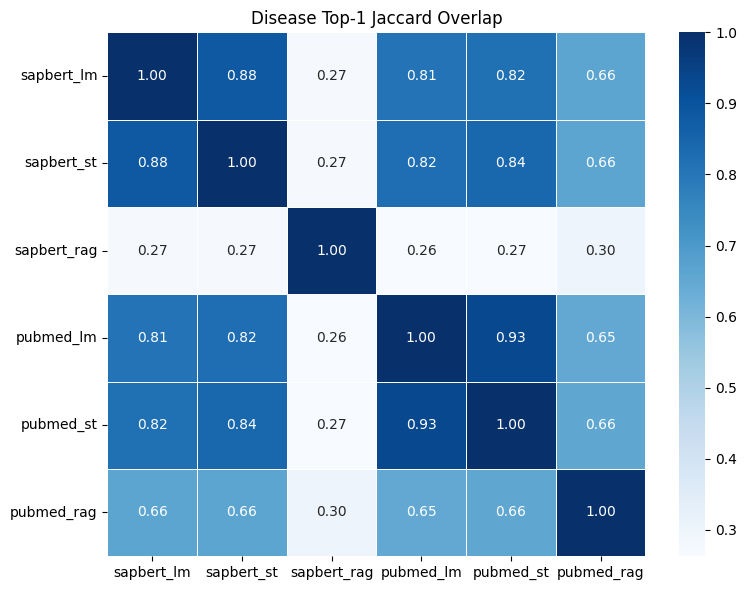

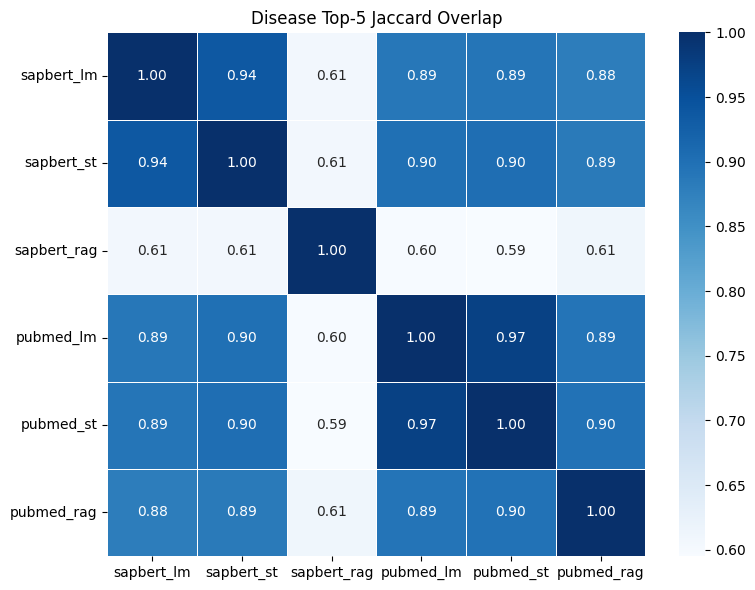

In [18]:
plot_heatmap(top1_overlap, "Disease Top-1 Jaccard Overlap")
plot_heatmap(top5_overlap, "Disease Top-5 Jaccard Overlap")

**Treatment**

In [19]:
# Updated code to pass the dict rather than a DataFrame
df = pd.read_csv(
    './data/corpus/cbio_treatment_name/trt_name_query_for_NCIT:C1909.csv')
large_corpus = pd.read_csv(
    'data/corpus/cbio_treatment_name/trt_name_corpus_from_NCIT:C1909.csv')

query_list = df['original_value'].tolist()
small_corpus_list = df['curated_ontology'].tolist()
large_corpus_list = large_corpus['label'].tolist()

cura_map = dict(zip(df['original_value'], df['curated_ontology']))

LM Strategy (SapBERT)

In [ ]:
# LM Strategy w/ SapBERT
other_params = {"test_or_prod": "test"}
onto_engine_large = ome.OntoMapEngine(method='sap-bert',
                                      category='treatment',
                                      topk=5,
                                      query=query_list,
                                      corpus=large_corpus_list,
                                      cura_map=cura_map,
                                      om_strategy='lm',
                                      **other_params)
lm_sapbert_result = onto_engine_large.run()

26/06//2025 08:18:1750951084 AM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:18:1750951084 AM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:18:1750951084 AM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:18:1750951084 AM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:18:1750951084 AM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:18:1750951084 AM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:18:1750951084 AM - INFO - OntoMapEngine: Separating exact and non-exact matches
26/06//2025 08:18:1750951084 AM - INFO - OntoMapEngine: Separating exact and non-exact matches
26/06//2025 08:18:1750951084 AM - INFO - OntoMapEngine: Separating exact and non-exact matches
26/06//2025 08:18:1750951084 AM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
26/06//2025 08:18:1750951084 AM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
26

No sentence-transformers model found with name model_cache/sap-bert. Creating a new one with mean pooling.
Batches: 100%|██████████| 14/14 [00:00<00:00, 71.36it/s]


In [21]:
lm_sapbert_accuracy_df = calc.calc_accuracy(lm_sapbert_result)
print(lm_sapbert_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  60.899654
1  Top 3 Matches  66.782007
2  Top 5 Matches  69.377163


In [22]:
lm_sapbert_result.to_csv("lm_sapbert_trt.csv", index=False)

In [7]:
# Language Model Strategy w/ PubMedBERT
other_params = {"test_or_prod": "test"}
onto_engine_large = ome.OntoMapEngine(method='pubmed-bert',
                                      category='treatment',
                                      topk=5,
                                      query=query_list,
                                      corpus=large_corpus_list,
                                      cura_map=cura_map,
                                      om_strategy='lm',
                                      **other_params)

lm_pubmedbert_result = onto_engine_large.run()

26/06//2025 03:07:1750975650 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 03:07:1750975650 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 03:07:1750975650 PM - INFO - OntoMapEngine: Separating exact and non-exact matches
26/06//2025 03:07:1750975650 PM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
26/06//2025 03:07:1750975650 PM - INFO - OntoMapLM: Initialized OntoMap Language Model module


Batches: 100%|██████████| 14/14 [00:00<00:00, 74.15it/s]


In [8]:
# Language Model Strategy w/ PubMedBERT
lm_pubmedbert_accuracy_df = calc.calc_accuracy(lm_pubmedbert_result)
print(lm_pubmedbert_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  54.325260
1  Top 3 Matches  59.515571
2  Top 5 Matches  61.418685


In [9]:
lm_pubmedbert_result.to_csv("lm_pubmedbert_trt.csv", index=False)

ST Strategy (PubMedBERT‑MS‑MARCO, SapBERT-mean-token)

In [ ]:
# ST Strategy w/ SapBERT-mean-token
other_params = {"test_or_prod": "test"}
onto_engine_large = ome.OntoMapEngine(method='mt-sap-bert',
                                      category='treatment',
                                      topk=5,
                                      query=query_list,
                                      corpus=large_corpus_list,
                                      cura_map=cura_map,
                                      om_strategy='st',
                                      **other_params)
st_sapbert_result = onto_engine_large.run()

26/06//2025 07:02:1750989756 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 07:02:1750989756 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 07:02:1750989756 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 07:02:1750989756 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 07:02:1750989756 PM - INFO - OntoMapEngine: Separating exact and non-exact matches
26/06//2025 07:02:1750989756 PM - INFO - OntoMapEngine: Separating exact and non-exact matches
26/06//2025 07:02:1750989756 PM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
26/06//2025 07:02:1750989756 PM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
26/06//2025 07:02:1750989756 PM - INFO - OntoMapST: Initialized OntoMap Sentence Transformer module


No sentence-transformers model found with name model_cache/mt-sap-bert. Creating a new one with mean pooling.
Batches: 100%|██████████| 14/14 [00:00<00:00, 80.93it/s]
No sentence-transformers model found with name cambridgeltl/SapBERT-from-PubMedBERT-fulltext-mean-token. Creating a new one with mean pooling.


In [12]:
st_sapbert_result.to_csv("st_sapbert_trt.csv", index=False)

In [11]:
st_sapbert_accuracy_df = calc.calc_accuracy(st_sapbert_result)
print(st_sapbert_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  61.418685
1  Top 3 Matches  66.955017
2  Top 5 Matches  69.550173


In [ ]:
# st - pubmed-bert
other_params = {"test_or_prod": "test"}
onto_engine_large = ome.OntoMapEngine(method='pubmed-bert',
                                      category='treatment',
                                      topk=5,
                                      query=query_list,
                                      corpus=large_corpus_list,
                                      cura_map=cura_map,
                                      om_strategy='st',
                                      **other_params)

st_pubmetbert_result = onto_engine_large.run()

26/06//2025 07:04:1750989860 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 07:04:1750989860 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 07:04:1750989860 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 07:04:1750989860 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 07:04:1750989860 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 07:04:1750989860 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 07:04:1750989860 PM - INFO - OntoMapEngine: Separating exact and non-exact matches
26/06//2025 07:04:1750989860 PM - INFO - OntoMapEngine: Separating exact and non-exact matches
26/06//2025 07:04:1750989860 PM - INFO - OntoMapEngine: Separating exact and non-exact matches
26/06//2025 07:04:1750989860 PM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
26/06//2025 07:04:1750989860 PM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
26

Batches: 100%|██████████| 14/14 [00:00<00:00, 62.87it/s]


In [14]:
# Sentences Transformer Strategy w/ PubMedBERT
st_pubmedbert_accuracy_df = calc.calc_accuracy(st_pubmetbert_result)
print(st_pubmedbert_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  54.671280
1  Top 3 Matches  59.342561
2  Top 5 Matches  61.418685


In [15]:
st_pubmetbert_result.to_csv("st_pubmedbert_trt.csv", index=False)

RAG

In [23]:
# RAG Strategy w/ SapBERT
rag_engine = ome.OntoMapEngine(method='mt-sap-bert',
                               category='treatment',
                               topk=5,
                               query=query_list,
                               corpus=large_corpus_list,
                               cura_map=cura_map,
                               om_strategy='rag',
                               test_or_prod='test')
rag_sapbert_result = rag_engine.run()

26/06//2025 08:21:1750951295 AM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:21:1750951295 AM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:21:1750951295 AM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:21:1750951295 AM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:21:1750951295 AM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:21:1750951295 AM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:21:1750951295 AM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:21:1750951295 AM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:21:1750951295 AM - INFO - OntoMapEngine: Separating exact and non-exact matches
26/06//2025 08:21:1750951295 AM - INFO - OntoMapEngine: Separating exact and non-exact matches
26/06//2025 08:21:1750951295 AM - INFO - OntoMapEngine: Separating exact and non-exact matches
26/06//2025 08:21:1750951295 AM

Batches: 100%|██████████| 13/13 [00:00<00:00, 28.14it/s]


26/06//2025 01:44:1750970659 PM - INFO - OntoMapRAG: Generating results table
26/06//2025 01:44:1750970659 PM - INFO - OntoMapRAG: Generating results table
26/06//2025 01:44:1750970659 PM - INFO - OntoMapRAG: Generating results table


Processing queries: 100%|██████████| 436/436 [00:10<00:00, 42.13it/s]


26/06//2025 01:44:1750970669 PM - INFO - OntoMapRAG: Results Generated
26/06//2025 01:44:1750970669 PM - INFO - OntoMapRAG: Results Generated
26/06//2025 01:44:1750970669 PM - INFO - OntoMapRAG: Results Generated


In [25]:
rag_sapbert_result.to_csv("rag_sapbert_trt.csv", index=False)

In [24]:
# RAG Strategy w/ SapBERT
rag_sapbert_accuracy_df = calc.calc_accuracy(rag_sapbert_result)
print(rag_sapbert_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  39.619377
1  Top 3 Matches  50.000000
2  Top 5 Matches  56.401384


In [20]:
# RAG Strategy w/ pubmed-bert
rag_engine = ome.OntoMapEngine(method='pubmed-bert',
                               category='treatment',
                               topk=5,
                               query=query_list,
                               corpus=large_corpus_list,
                               cura_map=cura_map,
                               om_strategy='rag',
                               test_or_prod='test')
rag_pubmed_result = rag_engine.run()

26/06//2025 08:03:1750993418 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:03:1750993418 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:03:1750993418 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:03:1750993418 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:03:1750993418 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:03:1750993418 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:03:1750993418 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:03:1750993418 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:03:1750993418 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:03:1750993418 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:03:1750993418 PM - INFO - OntoMapEngine: Separating exact and non-exact matches
26/06//2025 08:03:1750993418 PM - INFO - OntoMapEn

Processing queries: 100%|██████████| 436/436 [00:10<00:00, 42.89it/s]


26/06//2025 08:03:1750993429 PM - INFO - OntoMapRAG: Results Generated
26/06//2025 08:03:1750993429 PM - INFO - OntoMapRAG: Results Generated
26/06//2025 08:03:1750993429 PM - INFO - OntoMapRAG: Results Generated


In [18]:
rag_pubmed_result.to_csv("rag_pubmedbert_trt.csv", index=False)

In [17]:
# RAG Strategy w/ pubmed-bert
rag_pubmed_accuracy_df = calc.calc_accuracy(rag_pubmed_result)
print(rag_pubmed_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  48.442907
1  Top 3 Matches  58.996540
2  Top 5 Matches  63.840830


Bodysite

In [22]:
df = pd.read_csv(
    './data/corpus/cbio_body_site/body_site_query_for_NCIT:C32221.csv')
large_corpus = pd.read_csv(
    'data/corpus/cbio_body_site/body_site_corpus_from_NCIT:C32221.csv')

query_list = df['original_value'].tolist()
small_corpus_list = df['curated_ontology'].tolist()
large_corpus_list = large_corpus['label'].tolist()

cura_map = dict(zip(df['original_value'], df['curated_ontology']))

In [23]:
# LM Strategy w/ SapBERT
other_params = {"test_or_prod": "test"}
onto_engine_large = ome.OntoMapEngine(method='sap-bert',
                                      category='bodysite',
                                      topk=5,
                                      query=query_list,
                                      corpus=large_corpus_list,
                                      cura_map=cura_map,
                                      om_strategy='lm',
                                      **other_params)
lm_sapbert_result = onto_engine_large.run()

26/06//2025 08:08:1750993701 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:08:1750993701 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:08:1750993701 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:08:1750993701 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:08:1750993701 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:08:1750993701 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:08:1750993701 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:08:1750993701 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:08:1750993701 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:08:1750993701 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:08:1750993701 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:08:1750993701 PM - INFO - OntoMapEngine:

No sentence-transformers model found with name model_cache/sap-bert. Creating a new one with mean pooling.
Batches: 100%|██████████| 2/2 [00:00<00:00, 61.87it/s]


In [24]:
lm_sapbert_accuracy_df = calc.calc_accuracy(lm_sapbert_result)
print(lm_sapbert_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  51.708428
1  Top 3 Matches  75.398633
2  Top 5 Matches  80.865604


In [25]:
# Save the results
lm_sapbert_result.to_csv("lm_sapbert_bodysite.csv", index=False)

In [26]:
# LM Strategy w/ pubmed-bert
other_params = {"test_or_prod": "test"}
onto_engine_large = ome.OntoMapEngine(method='pubmed-bert',
                                      category='bodysite',
                                      topk=5,
                                      query=query_list,
                                      corpus=large_corpus_list,
                                      cura_map=cura_map,
                                      om_strategy='lm',
                                      **other_params)
lm_pubmedbert_result = onto_engine_large.run()

26/06//2025 08:10:1750993803 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:10:1750993803 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:10:1750993803 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:10:1750993803 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:10:1750993803 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:10:1750993803 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:10:1750993803 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:10:1750993803 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:10:1750993803 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:10:1750993803 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:10:1750993803 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:10:1750993803 PM - INFO - OntoM

Batches: 100%|██████████| 2/2 [00:00<00:00, 57.37it/s]


In [28]:
lm_pubmedbert_accuracy_df = calc.calc_accuracy(lm_pubmedbert_result)
print(lm_pubmedbert_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  58.542141
1  Top 3 Matches  79.271071
2  Top 5 Matches  84.738041


In [29]:
lm_pubmedbert_result.to_csv("lm_pubmedbert_bodysite.csv", index=False)

In [30]:
# ST Strategy w/ SapBERT-mean-token
other_params = {"test_or_prod": "test"}
onto_engine_large = ome.OntoMapEngine(method='mt-sap-bert',
                                      category='bodysite',
                                      topk=5,
                                      query=query_list,
                                      corpus=large_corpus_list,
                                      cura_map=cura_map,
                                      om_strategy='st',
                                      **other_params)
st_sapbert_result = onto_engine_large.run()

26/06//2025 08:11:1750993908 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:11:1750993908 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:11:1750993908 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:11:1750993908 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:11:1750993908 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:11:1750993908 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:11:1750993908 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:11:1750993908 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:11:1750993908 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:11:1750993908 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:11:1750993908 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:11:1750993908 PM - INF

Batches: 100%|██████████| 2/2 [00:00<00:00, 67.50it/s]
No sentence-transformers model found with name cambridgeltl/SapBERT-from-PubMedBERT-fulltext-mean-token. Creating a new one with mean pooling.


In [31]:
st_sapbert_accuracy_df = calc.calc_accuracy(st_sapbert_result)
print(st_sapbert_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  58.997722
1  Top 3 Matches  75.170843
2  Top 5 Matches  82.460137


In [32]:
st_sapbert_result.to_csv("st_sapbert_bodysite.csv", index=False)

In [33]:
# ST Strategy w/ pubmed-bert
other_params = {"test_or_prod": "test"}
onto_engine_large = ome.OntoMapEngine(method='pubmed-bert',
                                      category='bodysite',
                                      topk=5,
                                      query=query_list,
                                      corpus=large_corpus_list,
                                      cura_map=cura_map,
                                      om_strategy='st',
                                      **other_params)
st_pubmetbert_result = onto_engine_large.run()

26/06//2025 08:14:1750994041 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:14:1750994041 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:14:1750994041 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:14:1750994041 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:14:1750994041 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:14:1750994041 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:14:1750994041 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:14:1750994041 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:14:1750994041 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:14:1750994041 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:14:1750994041 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:14:1750994041

Batches: 100%|██████████| 2/2 [00:00<00:00, 56.69it/s]


In [34]:
st_pubmedbert_accuracy_df = calc.calc_accuracy(st_pubmetbert_result)
print(st_pubmedbert_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  58.542141
1  Top 3 Matches  75.854214
2  Top 5 Matches  82.687927


In [35]:
st_pubmetbert_result.to_csv("st_pubmedbert_bodysite.csv", index=False)

In [36]:
# RAG Strategy w/ sap-bert
rag_engine = ome.OntoMapEngine(method='mt-sap-bert',
                               category='bodysite',
                               topk=5,
                               query=query_list,
                               corpus=large_corpus_list,
                               cura_map=cura_map,
                               om_strategy='rag',
                               test_or_prod='test')
rag_sapbert_result = rag_engine.run()

26/06//2025 08:15:1750994124 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:15:1750994124 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:15:1750994124 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:15:1750994124 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:15:1750994124 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:15:1750994124 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:15:1750994124 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:15:1750994124 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:15:1750994124 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:15:1750994124 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 08:15:1750994124 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 08:15:1

Building context and records: 100%|██████████| 4128/4128 [00:00<00:00, 25123.06it/s]

26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite


26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion
26/06//2025 08:23:1750994630 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index in

Embedding batches: 100%|██████████| 9/9 [00:11<00:00,  1.30s/it]

26/06//2025 08:24:1750994641 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 08:24:1750994641 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 08:24:1750994641 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 08:24:1750994641 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 08:24:1750994641 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 08:24:1750994641 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 08:24:1750994641 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 08:24:1750994641 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 08:24:1750994641 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 08:24:1750994641 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing a


Processing queries: 100%|██████████| 439/439 [00:08<00:00, 49.99it/s]


26/06//2025 08:24:1750994650 PM - INFO - OntoMapRAG: Results Generated
26/06//2025 08:24:1750994650 PM - INFO - OntoMapRAG: Results Generated
26/06//2025 08:24:1750994650 PM - INFO - OntoMapRAG: Results Generated
26/06//2025 08:24:1750994650 PM - INFO - OntoMapRAG: Results Generated


In [38]:
rag_sapbert_result.to_csv("rag_sapbert_bodysite.csv", index=False)

In [37]:
rag_sapbert_accuracy_df = calc.calc_accuracy(rag_sapbert_result)
print(rag_sapbert_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  40.774487
1  Top 3 Matches  64.009112
2  Top 5 Matches  75.854214


In [41]:
# RAG Strategy w/ pubmed-bert
rag_engine = ome.OntoMapEngine(method='pubmed-bert',
                               category='bodysite',
                               topk=5,
                               query=query_list,
                               corpus=large_corpus_list,
                               cura_map=cura_map,
                               om_strategy='rag',
                               test_or_prod='test')
rag_pubmed_result = rag_engine.run()

26/06//2025 09:37:1750999048 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 09:37:1750999048 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 09:37:1750999048 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 09:37:1750999048 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 09:37:1750999048 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 09:37:1750999048 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 09:37:1750999048 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 09:37:1750999048 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 09:37:1750999048 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 09:37:1750999048 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 09:37:1750999048 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//202

Building context and records: 100%|██████████| 4128/4128 [00:00<00:00, 27714.51it/s]

26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Inserting 4154 records into SQLite
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLi

26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion
26/06//2025 09:46:1750999582 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index in

Embedding batches: 100%|██████████| 9/9 [00:12<00:00,  1.40s/it]

26/06//2025 09:46:1750999594 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 09:46:1750999594 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 09:46:1750999594 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 09:46:1750999594 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 09:46:1750999594 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 09:46:1750999594 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 09:46:1750999594 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 09:46:1750999594 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 09:46:1750999594 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 09:46:1750999594 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing a


Processing queries: 100%|██████████| 439/439 [00:09<00:00, 46.05it/s]


26/06//2025 09:46:1750999604 PM - INFO - OntoMapRAG: Results Generated
26/06//2025 09:46:1750999604 PM - INFO - OntoMapRAG: Results Generated
26/06//2025 09:46:1750999604 PM - INFO - OntoMapRAG: Results Generated
26/06//2025 09:46:1750999604 PM - INFO - OntoMapRAG: Results Generated
26/06//2025 09:46:1750999604 PM - INFO - OntoMapRAG: Results Generated
26/06//2025 09:46:1750999604 PM - INFO - OntoMapRAG: Results Generated


In [43]:
rag_pubmed_result.to_csv("rag_pubmed_bodysite.csv", index=False)

In [42]:
rag_pubmed_accuracy_df = calc.calc_accuracy(rag_pubmed_result)
print(rag_pubmed_accuracy_df)

  Accuracy Level   Accuracy
0    Top 1 Match  53.075171
1  Top 3 Matches  73.576310
2  Top 5 Matches  80.865604


Overlapping of different strategies

In [47]:
files = {
    'sapbert_lm': 'lm_sapbert_trt.csv',
    'sapbert_st': 'st_sapbert_trt.csv',
    'sapbert_rag': 'rag_sapbert_trt.csv',
    'pubmed_lm': 'lm_pubmedbert_trt.csv',
    'pubmed_st': 'st_pubmedbert_trt.csv',
    'pubmed_rag': 'rag_pubmedbert_trt.csv',
}

top1_dict = {}
top5_dict = {}

for name, path in files.items():
    df = pd.read_csv(path)
    top1_dict[name] = set(df[df['match_level'] == 1]['original_value'])
    top5_dict[name] = set(df[df['match_level'] <= 5]['original_value'])

top1_overlap = compute_overlap_matrix(top1_dict)
top5_overlap = compute_overlap_matrix(top5_dict)

print("🔹 Top1 Jaccard Overlap Matrix")
print(top1_overlap)

print("\n🔹 Top5 Jaccard Overlap Matrix")
print(top5_overlap)

🔹 Top1 Jaccard Overlap Matrix
            sapbert_lm sapbert_st sapbert_rag pubmed_lm pubmed_st pubmed_rag
sapbert_lm         1.0      0.916       0.579      0.83     0.825       0.69
sapbert_st       0.916        1.0       0.587     0.853     0.859      0.698
sapbert_rag      0.579      0.587         1.0     0.597     0.612      0.674
pubmed_lm         0.83      0.853       0.597       1.0     0.963      0.727
pubmed_st        0.825      0.859       0.612     0.963       1.0      0.748
pubmed_rag        0.69      0.698       0.674     0.727     0.748        1.0

🔹 Top5 Jaccard Overlap Matrix
            sapbert_lm sapbert_st sapbert_rag pubmed_lm pubmed_st pubmed_rag
sapbert_lm         1.0      0.935       0.683     0.839     0.853      0.791
sapbert_st       0.935        1.0       0.681     0.833     0.846      0.781
sapbert_rag      0.683      0.681         1.0     0.681     0.686      0.751
pubmed_lm        0.839      0.833       0.681       1.0     0.972      0.815
pubmed_st      

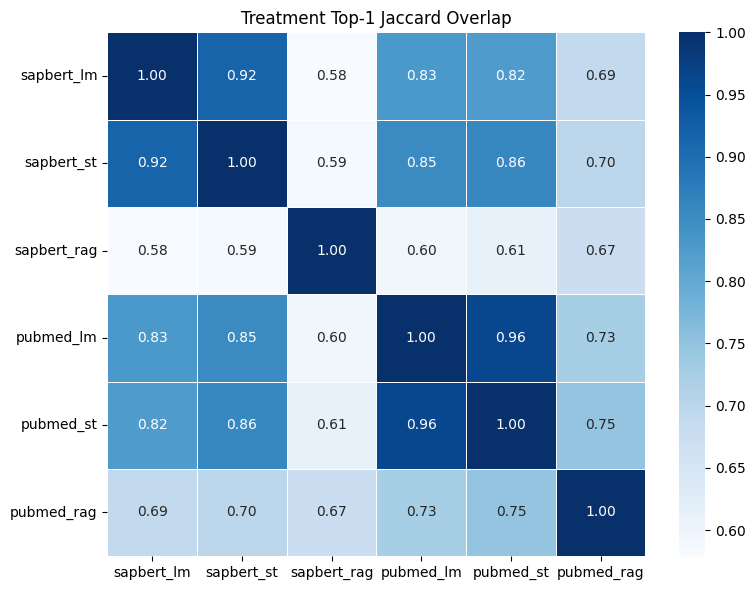

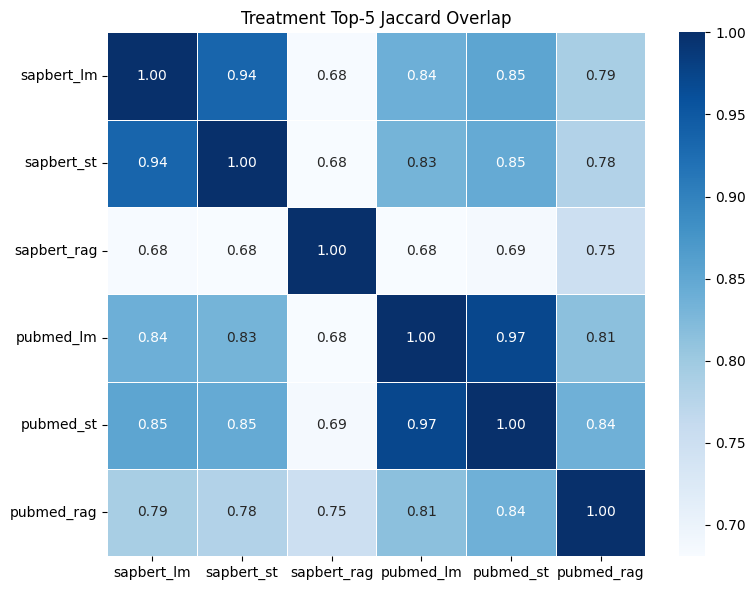

In [48]:
plot_heatmap(top1_overlap, "Treatment Top-1 Jaccard Overlap")
plot_heatmap(top5_overlap, "Treatment Top-5 Jaccard Overlap")

Test Sample

Find token count of a term

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "cambridgeltl/SapBERT-from-PubMedBERT-fulltext")
termList = [
    "Transformed B-Cell Lymphoma, Unclassifiable, with Features Intermediate between Diffuse Large B-Cell Lymphoma and Classic Hodgkin Lymphoma to Diffuse Large B-Cell Lymphoma",
    "Stage IV Childhood Malignant Kidney Neoplasm Excluding Renal Cell Carcinoma by Toronto Guidelines v2, International Society of Pediatric Oncology (SIOP) Protocol",
    "Localized Childhood Malignant Kidney Neoplasm Excluding Renal Cell Carcinoma by Toronto Guidelines v2, International Society of Pediatric Oncology (SIOP) Protocol",
    "Diphtheria Toxoid/Tetanus Toxoid/Acellular Pertussis Adsorbed, Recombinant Hepatitis B/Inactivated Poliovirus Vaccine Combined",
    "Stage IVC Unknown Primary Tumor (Except for EBV-Related and HPV-Related Tumors) and Metastatic Cervical Adenopathy AJCC v8",
    "Chrysanthemum morifolium/Ganoderma lucidum/Glycyrrhiza glabra/Isatis indigotica/Panax pseudoginseng/Rabdosia rubescens/Scutellaria baicalensis/Serona repens Supplement"
]

for term in termList:
    tokens = tokenizer(term, return_tensors='pt')
    token_count = len(tokens['input_ids'][0])

    print(f"Input term: {term}")
    print(f"Token count: {token_count}")
    # print(f"Tokens: {tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])}")

Input term: Transformed B-Cell Lymphoma, Unclassifiable, with Features Intermediate between Diffuse Large B-Cell Lymphoma and Classic Hodgkin Lymphoma to Diffuse Large B-Cell Lymphoma
Token count: 32
Input term: Stage IV Childhood Malignant Kidney Neoplasm Excluding Renal Cell Carcinoma by Toronto Guidelines v2, International Society of Pediatric Oncology (SIOP) Protocol
Token count: 27
Input term: Localized Childhood Malignant Kidney Neoplasm Excluding Renal Cell Carcinoma by Toronto Guidelines v2, International Society of Pediatric Oncology (SIOP) Protocol
Token count: 26
Input term: Diphtheria Toxoid/Tetanus Toxoid/Acellular Pertussis Adsorbed, Recombinant Hepatitis B/Inactivated Poliovirus Vaccine Combined
Token count: 25
Input term: Stage IVC Unknown Primary Tumor (Except for EBV-Related and HPV-Related Tumors) and Metastatic Cervical Adenopathy AJCC v8
Token count: 29
Input term: Chrysanthemum morifolium/Ganoderma lucidum/Glycyrrhiza glabra/Isatis indigotica/Panax pseudoginseng/R

Small corpora

In [8]:
# Test network connectivity
import requests
try:
    response = requests.get('https://huggingface.co', timeout=10, verify=False)
    print(f"Network connection is working: {response.status_code}")
except Exception as e:
    print(f"Network connection failed: {e}")

Network connection failed: maximum recursion depth exceeded while calling a Python object


In [40]:
import sqlite3

db_path = "src/KnowledgeDb/vector_db.sqlite"

conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS rag_pubmed_bert_bodysite;")

conn.commit()
conn.close()
print("rag_pubmed_bert_bodysite table dropped successfully.")


rag_pubmed_bert_bodysite table dropped successfully.


In [5]:
df = pd.read_csv('random_20_samples.csv')

query_list = df['original_value'].tolist()
small_corpus_list = df['curated_ontology'].tolist()

cura_map = dict(zip(df['original_value'], df['curated_ontology']))

In [ ]:
# rag Strategy w/
other_params = {"test_or_prod": "test"}
onto_engine_small = ome.OntoMapEngine(method='pubmed-bert',
                                      category='disease_sample',
                                      topk=5,
                                      query=query_list,
                                      corpus=small_corpus_list,
                                      cura_map=cura_map,
                                      om_strategy='rag',
                                      **other_params)
rag_pubmed_result = onto_engine_small.run()

26/06//2025 07:01:1750989664 PM - INFO - OntoMapEngine: Initialized OntoMap Engine module
26/06//2025 07:01:1750989664 PM - INFO - OntoMapEngine: Running Ontology Mapping
26/06//2025 07:01:1750989664 PM - INFO - OntoMapEngine: Separating exact and non-exact matches
26/06//2025 07:01:1750989664 PM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
26/06//2025 07:01:1750989664 PM - INFO - OntoMapRAG: Initialized OntoMapRAG module
26/06//2025 07:01:1750989671 PM - INFO - FAISSSQLiteSearch: Fetching NCI codes for 19 new terms
26/06//2025 07:01:1750989673 PM - INFO - UMLSDb: No NCI code found for term 'Borderline Ovarian Serous Tumor-Micropapillary Variant'
26/06//2025 07:01:1750989673 PM - INFO - UMLSDb: No NCI code found for term 'Breast Papillary Ductal Carcinoma with Invasion'
26/06//2025 07:01:1750989674 PM - INFO - FAISSSQLiteSearch: Retrieved codes for 17 terms
26/06//2025 07:01:1750989674 PM - INFO - FAISSSQLiteSearch: Fetching concept data for 17 unique codes
26/06

Building context and records: 100%|██████████| 17/17 [00:00<00:00, 9591.49it/s]

26/06//2025 07:01:1750989675 PM - INFO - FAISSSQLiteSearch: Inserting 17 records into SQLite
26/06//2025 07:01:1750989675 PM - INFO - FAISSSQLiteSearch: Starting vector embedding and FAISS index insertion



Embedding batches: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

26/06//2025 07:01:1750989676 PM - INFO - FAISSSQLiteSearch: Finished fetching and storing all terms.
26/06//2025 07:01:1750989676 PM - INFO - OntoMapRAG: Generating results table



Processing queries: 100%|██████████| 20/20 [00:00<00:00, 39.69it/s]

26/06//2025 07:01:1750989677 PM - INFO - OntoMapRAG: Results Generated


In [7]:
rag_pubmed_accuracy_df = calc.calc_accuracy(rag_pubmed_result)
print(rag_pubmed_accuracy_df)

  Accuracy Level  Accuracy
0    Top 1 Match      90.0
1  Top 3 Matches      90.0
2  Top 5 Matches      90.0


In [8]:
rag_pubmed_result

,original_value,curated_ontology,match_level,stage,top1_match,top1_score,top2_match,top2_score,top3_match,top3_score,top4_match,top4_score,top5_match,top5_score,top1_accuracy,top3_accuracy,top5_accuracy
0,ACUTE MEGAKARYOBLASTIC LEUKAEMIA,Acute Megakaryoblastic Leukemia,1,2,Acute Megakaryoblastic Leukemia,0.9429,Chondrosarcoma,0.8789,Small Cell Osteosarcoma,0.8742,Non-Hodgkin Lymphoma,0.8733,Cervical Endometrioid Adenocarcinoma,0.8712,True,True,True
1,ANAPLASTIC THYROID CANCER,Thyroid Gland Anaplastic Carcinoma,1,2,Thyroid Gland Anaplastic Carcinoma,0.9312,Thyroid Gland Carcinoma,0.9244,Thyroid Gland Sarcoma,0.9030,Papillary Carcinoma,0.8964,Head and Neck Basaloid Carcinoma,0.8842,True,True,True
2,"CARCINOMA, PAPILLARY",Papillary Carcinoma,1,2,Papillary Carcinoma,0.9604,Thyroid Gland Carcinoma,0.9274,Borderline Ovarian Clear Cell Tumor,0.9214,Head and Neck Basaloid Carcinoma,0.9168,Thyroid Gland Anaplastic Carcinoma,0.9141,True,True,True
3,CERVICAL ENDOMETRIOID CARCINOMA,Cervical Endometrioid Adenocarcinoma,1,2,Cervical Endometrioid Adenocarcinoma,0.9426,Ovarian High Grade Serous Adenocarcinoma,0.9015,Borderline Ovarian Clear Cell Tumor,0.8940,Chondrosarcoma,0.8820,Thyroid Gland Carcinoma,0.8795,True,True,True
4,CHONDROSARCOMA,Chondrosarcoma,1,2,Chondrosarcoma,0.9439,Small Cell Osteosarcoma,0.9019,Cervical Endometrioid Adenocarcinoma,0.8839,Sacrococcygeal Teratoma,0.8819,Ovarian High Grade Serous Adenocarcinoma,0.8758,True,True,True
5,CLEAR CELL BORDERLINE OVARIAN TUMOR,Borderline Ovarian Clear Cell Tumor,1,2,Borderline Ovarian Clear Cell Tumor,0.9572,Papillary Carcinoma,0.9079,Ovarian High Grade Serous Adenocarcinoma,0.9041,Cervical Endometrioid Adenocarcinoma,0.8928,Thyroid Gland Carcinoma,0.8842,True,True,True
6,GASTROINTESTINAL NEUROENDOCRINE,Digestive System Neuroendocrine Tumor,1,2,Digestive System Neuroendocrine Tumor,0.9246,Neuroendocrine Neoplasm,0.9041,Primitive Neuroectodermal Tumor,0.8649,Hilar Cholangiocarcinoma,0.8641,Thyroid Gland Carcinoma,0.8523,True,True,True
7,HEAD & NECK SQUAMOUS CELL CARCINOMA BASALOID TYPE,Head and Neck Basaloid Carcinoma,1,2,Head and Neck Basaloid Carcinoma,0.9578,Thyroid Gland Carcinoma,0.9159,Thyroid Gland Anaplastic Carcinoma,0.9120,Papillary Carcinoma,0.9084,Ovarian High Grade Serous Adenocarcinoma,0.9032,True,True,True
8,HGS,Ovarian High Grade Serous Adenocarcinoma,1,2,Ovarian High Grade Serous Adenocarcinoma,0.8796,Non-Hodgkin Lymphoma,0.8698,Hilar Cholangiocarcinoma,0.8589,Cervical Endometrioid Adenocarcinoma,0.8587,Chondrosarcoma,0.8574,True,True,True
9,MALIGNANT SACROCOCCYGEAL TERATOMA,Sacrococcygeal Teratoma,1,2,Sacrococcygeal Teratoma,0.9433,Chondrosarcoma,0.9040,Ovarian High Grade Serous Adenocarcinoma,0.8915,Primitive Neuroectodermal Tumor,0.8876,Cervical Endometrioid Adenocarcinoma,0.8855,True,True,True


In [6]:
# rag Strategy w/
other_params = {"test_or_prod": "test"}
onto_engine_small = ome.OntoMapEngine(method='mt-sap-bert',
                                      category='disease_sample',
                                      topk=5,
                                      query=query_list,
                                      corpus=small_corpus_list,
                                      cura_map=cura_map,
                                      om_strategy='rag',
                                      **other_params)
rag_sapbert_result = onto_engine_small.run()

27/06//2025 12:32:1751009544 AM - INFO - OntoMapEngine: Initialized OntoMap Engine module
27/06//2025 12:32:1751009544 AM - INFO - OntoMapEngine: Running Ontology Mapping
27/06//2025 12:32:1751009544 AM - INFO - OntoMapEngine: Separating exact and non-exact matches
27/06//2025 12:32:1751009544 AM - INFO - OntoMapEngine: Running OntoMap model for non-exact matches
27/06//2025 12:32:1751009544 AM - INFO - OntoMapRAG: Initialized OntoMapRAG module


No sentence-transformers model found with name model_cache/mt-sap-bert. Creating a new one with mean pooling.


27/06//2025 12:32:1751009571 AM - INFO - OntoMapRAG: Generating results table


Processing queries: 100%|██████████| 20/20 [00:01<00:00, 13.89it/s]

27/06//2025 12:32:1751009572 AM - INFO - OntoMapRAG: Results Generated


In [7]:
rag_sapbert_accuracy_df = calc.calc_accuracy(rag_sapbert_result)
print(rag_sapbert_accuracy_df)

  Accuracy Level  Accuracy
0    Top 1 Match      90.0
1  Top 3 Matches      90.0
2  Top 5 Matches      90.0
